In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
#%pylab
%matplotlib inline
import pandas as pd
import json

In [6]:
#### Read in USAspending.gov data and append 2015 gdp data and fips ID for later merge
contracts_2015 = pd.read_csv('data/2015_All_Contracts_Full_20170115.csv',
                             memory_map = True,
                             usecols = ['dollarsobligated',
                                        'pop_state_code',
                                        'placeofperformancezipcode',
                                        ],
                             dtype = {'dollarsobligated': np.float64,
                                       'pop_state_code':  str,
                                       'placeofperformancezipcode': str,
                                       }
                            )
contracts_2015['fed_funding_amount'] = contracts_2015['dollarsobligated']
#contracts_2015['zip'] = contracts_2015['placeofperformancezipcode'].apply(lambda x: str(x)[:5])
contracts_2015['STATE'] = contracts_2015['pop_state_code'].apply(lambda x: str(x)[:2])
print 'doing loans'

loans_2015 = pd.read_csv('data/2015_All_Loans_Full_20170115.csv',
                             #memory_map = True,
                             usecols = ['fed_funding_amount',
                                        #'principal_place_state',
                                        'principal_place_zip',
                                        'principal_place_state_code'
                                        ],
                             dtype = {'fed_funding_amount': np.float64,
                                       'principal_place_state':  str,
                                       'principal_place_zip': str,
                                       'principal_place_state_code': str
                                       }
                            )

#loans_2015['zip'] = loans_2015['principal_place_zip'].apply(lambda x: str(x)[:5])

loans_2015['STATE'] = loans_2015['principal_place_state_code'].apply(lambda x: str(x)[:2])





print 'doing grants'


grants_2015 = pd.read_csv('data/2015_All_Grants_Full_20170115.csv',
                             #memory_map = True,
                             usecols = ['fed_funding_amount',
                                        'principal_place_state_code',
                                        #'principal_place_zip',
                                        #'principal_place_state'
                                        ],
                             dtype = {'fed_funding_amount': np.float64,
                                       'principal_place_state_code':  str,
                                       #'principal_place_zip': str,
                                       #'principal_place_state': str
                                       }
                            )

#grants_2015['zip'] = grants_2015['principal_place_zip'].apply(lambda x: str(x)[:5])
grants_2015['STATE'] = grants_2015['principal_place_state_code'].apply(lambda x: str(x)[:2])




print 'doing others'

other_2015 = pd.read_csv('data/2015_All_Other_Full_20170115.csv',
                             memory_map = True,
                             usecols = ['fed_funding_amount',
                                       'principal_place_state_code',
                                       #'principal_place_zip',
                                       #'principal_place_state'
                                       ],
                             dtype = {'fed_funding_amount': np.float64,
                                      'principal_place_state_code':  str,
                                      'principal_place_zip': str,
                                      'principal_place_state': str
                                      }
                            )

#other_2015['zip'] = other_2015['principal_place_zip'].apply(lambda x: str(x)[:5])

other_2015['STATE'] = other_2015['principal_place_state_code'].apply(lambda x: str(x)[:2])





doing loans
doing grants
doing others


In [63]:
### Read in employment data 
employment_2015 = pd.read_csv('data/2000.q1-q4.singlefile.csv',
                              memory_map = True,
                             usecols = ['area_fips',
                                        'agglvl_code', 
                                        'avg_wkly_wage',
                                        'industry_code',
                                        'own_code',
                                        'qtr'
                                       ],
                             dtype = {'area_fips': str,
                                       'agglvl_code':  str,
                                       'avg_wkly_wage': np.float64,
                                       'industry_code': str,
                                      'own_code': str,
                                      'qtr': str
                                       } 
                            ).groupby('agglvl_code').get_group('50')


state2fips = pd.read_csv('data/StateFIPS/Sheet1-Table 1.csv',
                         usecols = ['FIPS', 'AB'],
                         dtype = {'FIPS':str,
                                 'AB':str
                                 }
                        )
# f = open('data/zip2fips/zip2fips.json')
# s = f.read()
# zip2fips = json.loads(s)
# zip2fips = pd.DataFrame.from_dict(zip2fips, orient = 'index')
# f.close()

# zip2fips['zip'] = zip2fips.index
# zip2fips['zip'] = zip2fips['zip'].apply(lambda x: str(x))
# zip2fips.columns = ['fips', 'zip']
# zip2fips['fips'] = zip2fips['fips'].apply(lambda x: str(x))


# zip2fips.index = zip2fips['fips']
state2fips['FIPS'] = state2fips['FIPS'].apply(lambda x: x.zfill(2)) + '000'
state2fips.index = state2fips['FIPS']
employment_2015 = employment_2015.join(state2fips['AB'], on = 'area_fips')
employment_2015.columns = pd.Index([u'area_fips', u'own_code', u'industry_code', u'agglvl_code', u'qtr',
       u'avg_wkly_wage', u'STATE'],
      dtype='object')


In [38]:
muni_to_county_fips = pd.read_csv('data/fips_codes_website.csv', 
                                    usecols = ['State FIPS Code', 
                                               'County FIPS Code',
                                               'FIPS Entity Code'],
                                    dtype = {'State FIPS Code': str,
                                            'County FIPS Code': str,
                                            'FIPS Entity Code': str,
                                            }
                                   )
muni_to_county_fips['CountyFIPS'] = muni_to_county_fips['State FIPS Code'] + muni_to_county_fips['County FIPS Code']

In [43]:
muni_to_county_fips.index = muni_to_county_fips['FIPS Entity Code']


,Fips,Area,2015,State FIPS Code,County FIPS Code,FIPS Entity Code,CountyFIPS
Fips,,,,,,,
00998,00998,United States (Metropolitan Portion),16204029.0,NaN,NaN,NaN,NaN
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,04,013,10180,04013
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,23,005,10180,23005
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,26,159,10180,26159
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,27,109,10180,27109
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,31,041,10180,31041
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,38,043,10180,38043
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,46,123,10180,46123
10180,10180,"Abilene, TX (Metropolitan Statistical Area)",6499.0,47,137,10180,47137


In [71]:

federal_2015 = pd.concat([contracts_2015[['fed_funding_amount','STATE']], 
                          loans_2015[['fed_funding_amount','STATE']], 
                          grants_2015[['fed_funding_amount','STATE']], 
                          other_2015[['fed_funding_amount','STATE']]
                         ],
                         ignore_index = True
                        )


gdp_2015 = pd.read_csv('data/state_gdp_2015.csv', header = 1, skiprows = 3,
                      usecols=['Fips', '2015Q1', 'IndCode'],
                      dtype = {'Fips': str,
                              '2015Q1': 'object',
                              'IndCode': int
                              }
                      )
gdp_2015 = gdp_2015.groupby('IndCode').get_group(1)
gdp_2015['2015Q1']= gdp_2015['2015Q1'].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

#gdp_2015 = gdp_2015.join(muni_to_county_fips['CountyFIPS'], on = 'Fips')
#gdp_2015.index = gdp_2015['CountyFIPS']
#locs = ~gdp_2015['CountyFIPS'].isnull()
#gdp_2015 = gdp_2015.loc[locs, :]

#zip2fips.index = zip2fips['zip']

#federal_2015 = federal_2015.join(zip2fips['fips'], on = 'zip')
state2fips.index = state2fips.AB
gdp_2015.index = gdp_2015.Fips
federal_2015 = federal_2015.join(state2fips, on = 'STATE')


federal_2015 = federal_2015.join(gdp_2015['2015Q1'], on = 'FIPS')

,Fips,IndCode,2015Q1
Fips,,,
01000,01000,1,197479
02000,02000,1,53364
04000,04000,1,286045
05000,05000,1,116930
06000,06000,1,2438787
08000,08000,1,309638
09000,09000,1,249397
10000,10000,1,67926
11000,11000,1,120645


In [72]:
grouped_employment = employment_2015.groupby('STATE')
grouped_fed_spending = federal_2015.groupby('STATE')

In [115]:
states = []
wages = []
gdp_from_contracts = []
for index, row in state2fips.iterrows():
    state = row['AB']
    success = 1
#     try:
#         e_group = grouped_employment.get_group(zipcode)
#     except:
#         success = 0
#         pass
    try:
        fed_group = grouped_fed_spending.get_group(state)
    except:
        success = 0
        pass
    if success == 1: 
        emp_group = grouped_employment.get_group(state)
        wages += [emp_group.avg_wkly_wage.mean()]
        gdp_from_contracts += [(fed_group.fed_funding_amount/(1.0e6 * fed_group['2015Q1'])).sum()]
        states += [state]

In [95]:

zip_dataframe = pd.DataFrame({'zip':states, 'fed_cont_to_gdp':gdp_from_contracts})

In [96]:
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc',
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-130.2, llcrnrlat= 23.9, urcrnrlon=-65.6, urcrnrlat=50.1)



In [97]:

m.readshapefile('data/cb_2015_us_state_500k/cb_2015_us_state_500k', 'areas', 
                linewidth = 0, 
                drawbounds = False,
                antialiased = False)
poly_data = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.areas], 
                         'area':[area['STUSPS'] for area in m.areas_info]})
poly_data = poly_data.merge(zip_dataframe, left_on='area', right_on = 'zip', how = 'left')



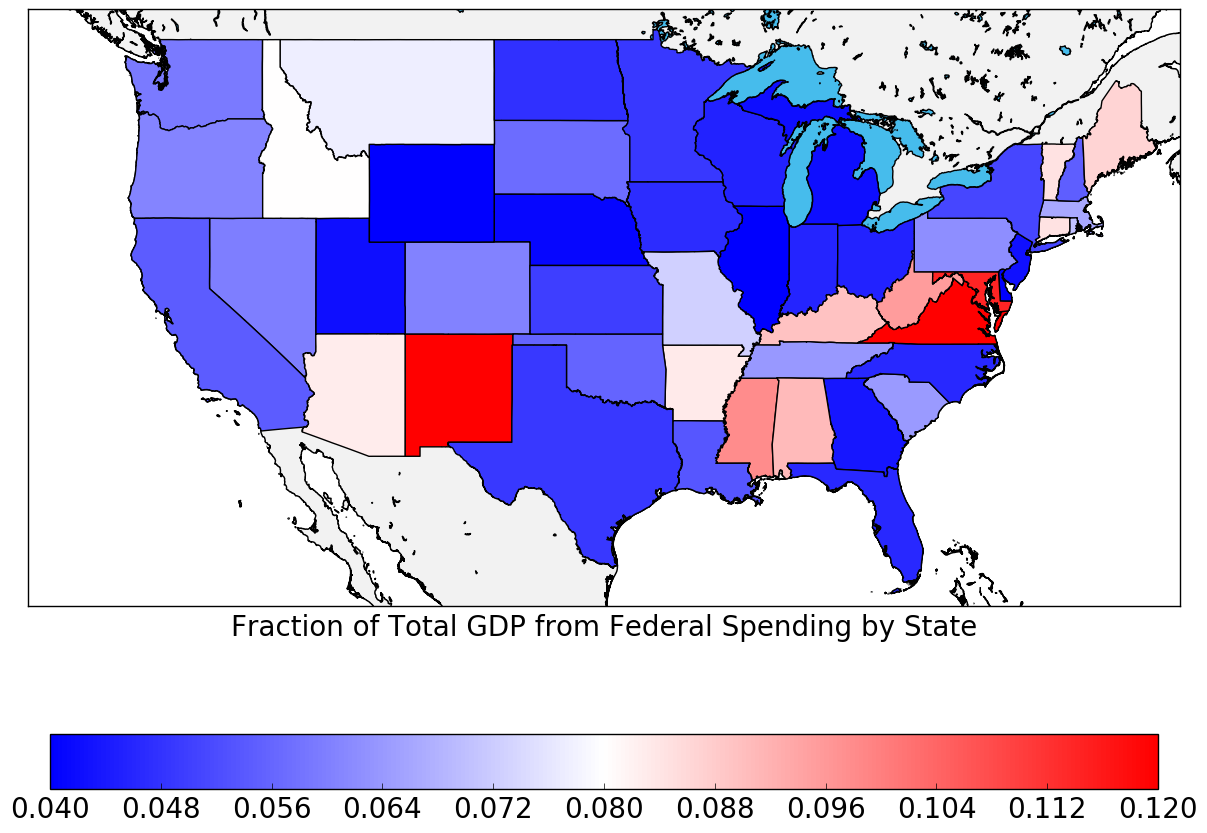

In [165]:
fig, ax = plt.subplots(figsize=(22,11))

#m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
cmap = plt.get_cmap('bwr')
pc = PatchCollection(poly_data.shapes, zorder = 2, match_original = True)
norm = Normalize(vmin = 0.04, vmax = 0.12, clip = True)
pc.set_facecolor(cmap(norm(((poly_data['fed_cont_to_gdp'].fillna(0).values)))))
ax.add_collection(pc)
ax.set_xlabel(r'Fraction of Total GDP from Federal Spending by State', fontsize= 20)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(((poly_data['fed_cont_to_gdp'])))
cbar = plt.colorbar(mapper,shrink = 0.65, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=20) 
#cbar.set_label(, size=220)

In [ ]:
ax = subplot(111)
ax.hist(federal_2015['fed_funding_amount'],bins= logspace(1,9,25));
ax.hist(-federal_2015['fed_funding_amount'],bins= logspace(1,9,25));
ax.set_xscale('log')


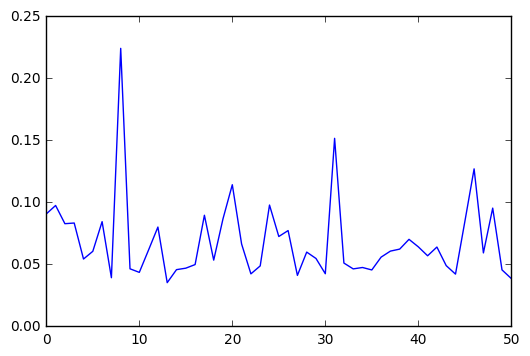

In [94]:
plot(gdp_from_contracts)

In [ ]:
federal_2015

(array([ 20.,  15.,   9.,   3.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.03531435,  0.05420983,  0.07310531,  0.09200078,  0.11089626,
         0.12979173,  0.14868721,  0.16758269,  0.18647816,  0.20537364,
         0.22426912]),
 <a list of 10 Patch objects>)

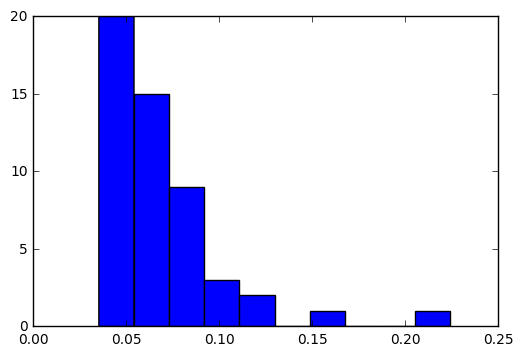

In [99]:
hist(gdp_from_contracts)

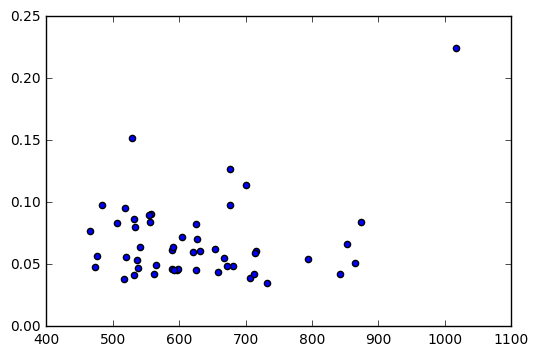

In [118]:
scatter(wages, gdp_from_contracts)

In [151]:
bin1 = range(401,551)
bin2 = range(551,701)
bin3 = range(701,1101)
vec1 = [gdp for wage, gdp in zip(wages, gdp_from_contracts) if wage in bin1]
vec2= [gdp for wage, gdp in zip(wages, gdp_from_contracts) if wage in bin2]
vec3 = [gdp for wage, gdp in zip(wages, gdp_from_contracts) if wage in bin3]

([<matplotlib.axis.XTick at 0x12e4ec050>,
 <a list of 3 Text xticklabel objects>)

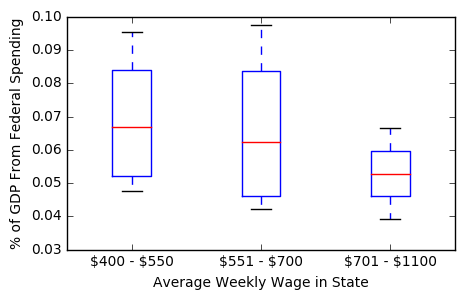

In [168]:
figure(figsize = (5, 3))
boxplot([vec1,vec2,vec3]);
ylabel(r'% of GDP From Federal Spending', fontsize = 10)
xlabel('Average Weekly Wage in State', fontsize = 10)
xticks(arange(1,4), ['\$400 - \$550', '\$551 - \$700', '\$701 - \$1100'])

In [141]:
518 in bin3

False

In [147]:
600 in bin1 + bin2 + bin3

True